<a href="https://colab.research.google.com/github/StillWork/ds0315/blob/main/h_34_PM_LSTM2_210418.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 이용한 PM

In [1]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()
%config InlineBackend.figure_format = 'retina'

In [2]:
# !cat /proc/meminfo

In [3]:
# !cat /proc/cpuinfo

In [4]:
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_test.txt -O PM_test.txt 
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_train.txt -O PM_train.txt  
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt -O PM_truth.txt

In [5]:
!ls

PM_test.txt  PM_train.txt  PM_truth.txt  sample_data


# Binary classification
Predict if an asset will fail within certain time frame (e.g. cycles)

In [6]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = 'binary_model.h5'

## Data Ingestion

In [7]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


## Data Preprocessing

In [8]:
# 훈련 데이터 처리, RUL: Remaining Useful Lifetime = ttf
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# 이진 분류와 3진 분류를 위한 레이블
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# TEST 데이터 처리

# MinMax normalization (from 0 to 1)
# (주의!) cycle도 스케일링 했다

test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


# 정답 데이터 반영 (테스트 데이터에 대한 정답 - 실제 종료 시각은 덧셈을 해주어야 한다)

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [9]:
# 윈도우 크기
sequence_length = 50

# (samples, time steps, features) 구조를 갖도록 조작
def gen_sequence(id_df, seq_length, seq_cols):
    #  패딩을 사용하지 않고 윈도우 보다 작은 데이터는 버린다
    # 입력으로 1차원 벡터가 아니라 다차원 벡터가 사용된다 (텐서)
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # 한 샘플(행)씩 이동하면서 데이터를 준비한다 (split_seq와 유사한 동작을 하며 부족한 데이터는
    # 만들지 않는다)
    # 이를 위해서 generator를 사용한다 (return 대신 yield 사용)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 141 191 -> from row 141 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# 특성 선택
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape


(15631, 50, 25)

## 윈도우 크기 50을 바꾸어 본다

In [10]:


# function to generate labels
def gen_labels(id_df, seq_length, label):
    # 각 엔진에 대해서 레이블을 매트릭스로 만든다
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # 앞의 seq_length 개의 레이블을 삭제해야 한다 (50개의 입력이 들어온 후에 출력이 나오므로)
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(15631, 1)

In [11]:
# LSTM 설계
# 100개의 셀(Unit)을 사용한다. 이 출력을 다시 50개의 셀을 가진 LSTM 층으로 보낸다 (2 레이어)
# 과대적합을 줄이기 위해 Dropout 사용한다
# 출력단은 이진분류
# 
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True)) # 한개의 층이 더 있고, 이곳으로 데이터를 보낸다
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           50400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


Epoch 1/100
75/75 - 33s - loss: 0.2607 - accuracy: 0.8875 - val_loss: 0.0904 - val_accuracy: 0.9706
Epoch 2/100
75/75 - 1s - loss: 0.0953 - accuracy: 0.9617 - val_loss: 0.0401 - val_accuracy: 0.9898
Epoch 3/100
75/75 - 1s - loss: 0.0810 - accuracy: 0.9669 - val_loss: 0.0546 - val_accuracy: 0.9783
Epoch 4/100
75/75 - 1s - loss: 0.0726 - accuracy: 0.9710 - val_loss: 0.0621 - val_accuracy: 0.9744
Epoch 5/100
75/75 - 1s - loss: 0.0703 - accuracy: 0.9707 - val_loss: 0.0713 - val_accuracy: 0.9680
Epoch 6/100
75/75 - 1s - loss: 0.0688 - accuracy: 0.9725 - val_loss: 0.0399 - val_accuracy: 0.9834
Epoch 7/100
75/75 - 1s - loss: 0.0613 - accuracy: 0.9751 - val_loss: 0.0392 - val_accuracy: 0.9859
Epoch 8/100
75/75 - 1s - loss: 0.0547 - accuracy: 0.9768 - val_loss: 0.0491 - val_accuracy: 0.9770
Epoch 9/100
75/75 - 1s - loss: 0.0539 - accuracy: 0.9765 - val_loss: 0.0365 - val_accuracy: 0.9859
Epoch 10/100
75/75 - 1s - loss: 0.0539 - accuracy: 0.9775 - val_loss: 0.0448 - val_accuracy: 0.9808
Epoch 11

In [13]:
history.history.keys()  # fistory 키값 보기

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Model Evaluation on Test set

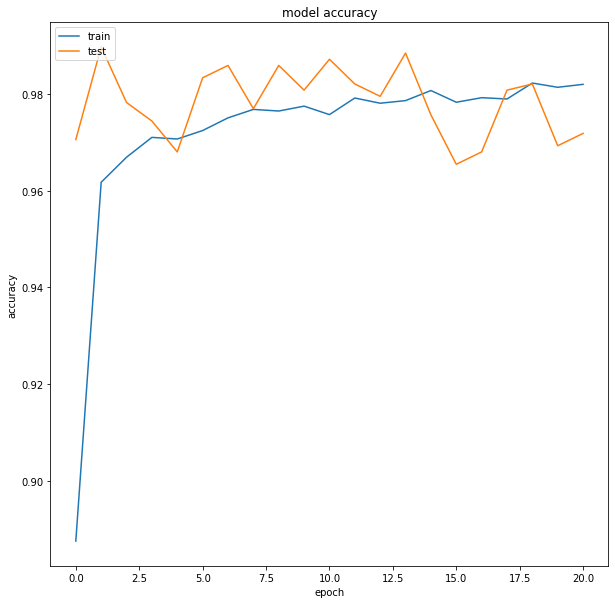

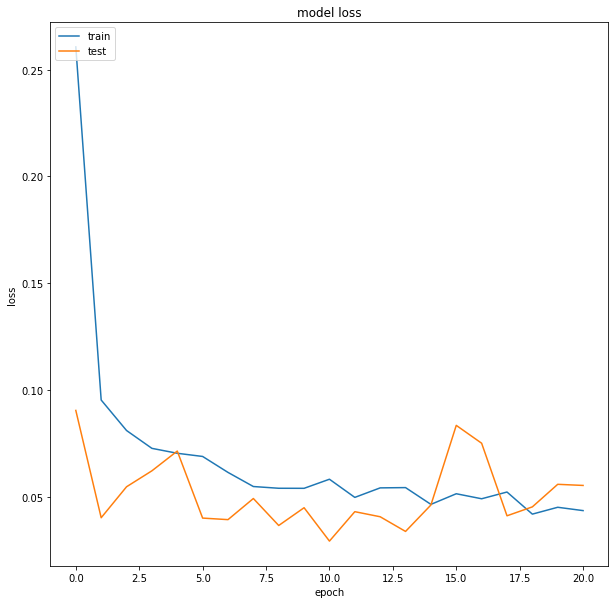

79/79 [==============================] - 0s 5ms/step - loss: 0.0435 - accuracy: 0.9819
Accurracy: 0.9818949699401855


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


79/79 [==============================] - 1s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12331   200]
 [   83  3017]]
precision =  0.9378302766552689 
 recall =  0.9732258064516129


In [14]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Evaluation on Validation set

3/3 - 1s - loss: 0.0539 - accuracy: 0.9677
Accurracy: 0.9677419066429138


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 1 24]]
Precision:  0.9230769230769231 
 Recall:  0.96 
 F1-score: 0.9411764705882353


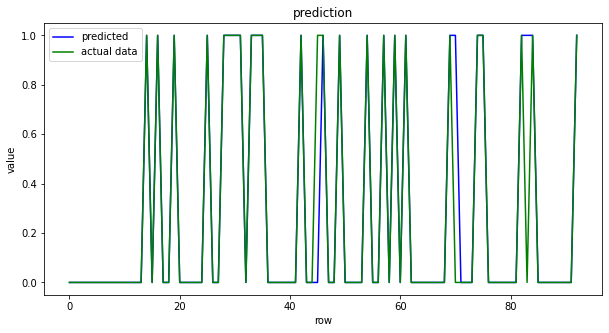

In [15]:
# We pick the last sequence for each id in the test data

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
#print("y_mask")
#print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

# Regression
How many more cycles an in-service engine will last before it fails?

In [16]:
# import keras
# import keras.backend as K
# from keras.layers.core import Activation
# from keras.models import Sequential,load_model
# from keras.layers import Dense, Dropout, LSTM

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from sklearn import preprocessing

# # Setting seed for reproducibility
# np.random.seed(1234)  
# PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model.h5'

## Data Ingestion

In [ ]:
# train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
# train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
# train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#                      's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#                      's15', 's16', 's17', 's18', 's19', 's20', 's21']

# train_df = train_df.sort_values(['id','cycle'])

# # read test data - It is the aircraft engine operating data without failure events recorded.
# test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
# test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
# test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#                      's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#                      's15', 's16', 's17', 's18', 's19', 's20', 's21']

# # read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
# truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
# truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

## Data Preprocessing

In [17]:
# ##################################
# # Data Preprocessing
# ##################################

# #######
# # TRAIN
# #######
# # Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
# rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
# rul.columns = ['id', 'max']
# train_df = train_df.merge(rul, on=['id'], how='left')
# train_df['RUL'] = train_df['max'] - train_df['cycle']
# train_df.drop('max', axis=1, inplace=True)

# # generate label columns for training data
# # we will only make use of "label1" for binary classification, 
# # while trying to answer the question: is a specific engine going to fail within w1 cycles?
# w1 = 30
# w0 = 15
# train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
# train_df['label2'] = train_df['label1']
# train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# # MinMax normalization (from 0 to 1)
# train_df['cycle_norm'] = train_df['cycle']
# cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
# min_max_scaler = preprocessing.MinMaxScaler()
# norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
#                              columns=cols_normalize, 
#                              index=train_df.index)
# join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
# train_df = join_df.reindex(columns = train_df.columns)

# #train_df.to_csv('PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)

# ######
# # TEST
# ######
# # MinMax normalization (from 0 to 1)
# test_df['cycle_norm'] = test_df['cycle']
# norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
#                             columns=cols_normalize, 
#                             index=test_df.index)
# test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
# test_df = test_join_df.reindex(columns = test_df.columns)
# test_df = test_df.reset_index(drop=True)
# print(test_df.head())

# # We use the ground truth dataset to generate labels for the test data.
# # generate column max for test data
# rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
# rul.columns = ['id', 'max']
# truth_df.columns = ['more']
# truth_df['id'] = truth_df.index + 1
# truth_df['max'] = rul['max'] + truth_df['more']
# truth_df.drop('more', axis=1, inplace=True)

# # generate RUL for test data
# test_df = test_df.merge(truth_df, on=['id'], how='left')
# test_df['RUL'] = test_df['max'] - test_df['cycle']
# test_df.drop('max', axis=1, inplace=True)

# # generate label columns w0 and w1 for test data
# test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
# test_df['label2'] = test_df['label1']
# test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

# #test_df.to_csv('PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

# # pick a large window size of 50 cycles
# sequence_length = 50

# # function to reshape features into (samples, time steps, features) 
# def gen_sequence(id_df, seq_length, seq_cols):
#     """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
#     we need to drop those which are below the window-length. An alternative would be to pad sequences so that
#     we can use shorter ones """
#     # for one id I put all the rows in a single matrix
#     data_matrix = id_df[seq_cols].values
#     num_elements = data_matrix.shape[0]
#     # Iterate over two lists in parallel.
#     # For example id1 have 192 rows and sequence_length is equal to 50
#     # so zip iterate over two following list of numbers (0,112),(50,192)
#     # 0 50 -> from row 0 to row 50
#     # 1 51 -> from row 1 to row 51
#     # 2 52 -> from row 2 to row 52
#     # ...
#     # 111 191 -> from row 111 to 191
#     for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
#         yield data_matrix[start:stop, :]
        
# # pick the feature columns 
# sensor_cols = ['s' + str(i) for i in range(1,22)]
# sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
# sequence_cols.extend(sensor_cols)

# # TODO for debug 
# # val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
# val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
# print(len(val))

# # generator for the sequences
# # transform each id of the train dataset in a sequence
# seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
#            for id in train_df['id'].unique())

# # generate sequences and convert to numpy array
# seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
# print(seq_array.shape)

# # function to generate labels
# def gen_labels(id_df, seq_length, label):
#     """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
#     we need to drop those which are below the window-length. An alternative would be to pad sequences so that
#     we can use shorter ones """
#     # For one id I put all the labels in a single matrix.
#     # For example:
#     # [[1]
#     # [4]
#     # [1]
#     # [5]
#     # [9]
#     # ...
#     # [200]] 
#     data_matrix = id_df[label].values
#     num_elements = data_matrix.shape[0]
#     # I have to remove the first seq_length labels
#     # because for one id the first sequence of seq_length size have as target
#     # the last label (the previus ones are discarded).
#     # All the next id's sequences will have associated step by step one label as target.
#     return data_matrix[seq_length:num_elements, :]

# # generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## LSTM

In [18]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
__________________________________________________

## Model Evaluation on Test set
- 회귀 모델

In [19]:
history.history.keys()

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])

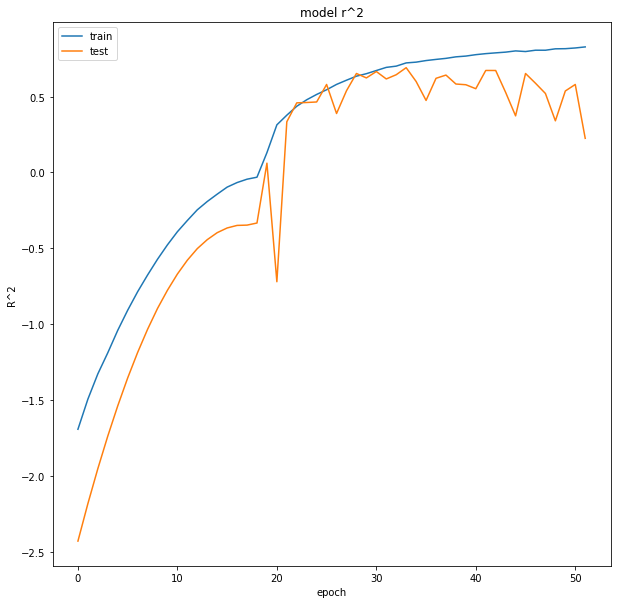

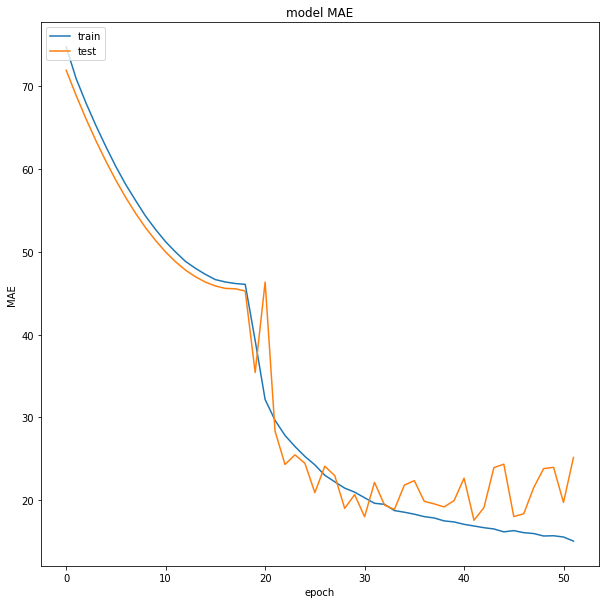

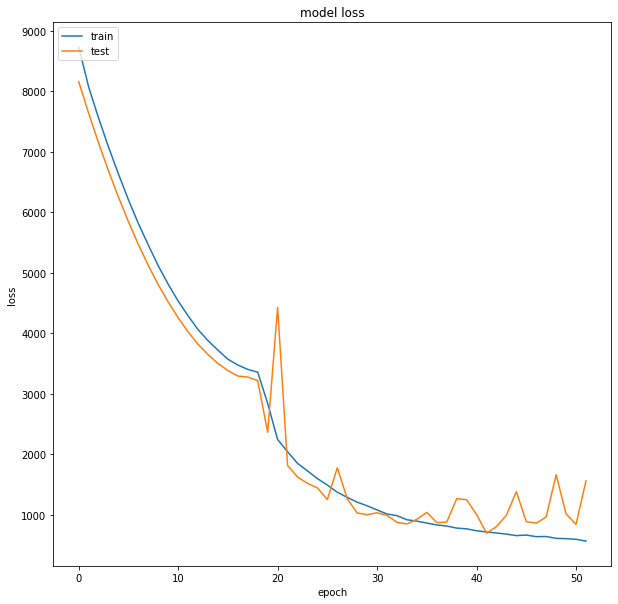

79/79 [==============================] - 0s 5ms/step - loss: 710.5965 - mae: 17.7065 - r2_keras: 0.6768

MAE: 17.7065486907959

R^2: 0.6767993569374084
79/79 [==============================] - 1s 4ms/step


In [20]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

## Evaluate on Validation set
- 오류 발생!

In [21]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, 
                                     label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

TypeError: ignored

# References


- [1] Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
- [2] Predictive Maintenance: Step 2A of 3, train and evaluate regression models https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2
- [3] A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA 
- [4] Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/

